In [1]:
import numpy as np
from epyt import epanet
import ray
from ray.rllib.algorithms.algorithm import Algorithm

from esc.water_usage import MINUTES_PER_DAY, TYPICAL_BUILDING_MEAN_WATER_CONSUMPTION_LITER_PER_MINUTE, relative_occupant_water_demand
from esc.electricity_rates import electricity_rate
from esc.util import minute_in_day
from esc.reward import reward_high_tank_head, reward_low_energy_cost
from esc.water_usage import relative_occupant_water_demand


In [2]:
relative_occupant_water_demand(np.arange(-10, 0))

array([0.43711377, 0.39858181, 0.39599269, 0.35200029, 0.43999198,
       0.4183432 , 0.39488734, 0.26347688, 0.34326304, 0.45604203])

In [3]:
ray.init()

2022-12-01 11:05:17,591	INFO worker.py:1528 -- Started a local Ray instance.


Python version:,3.10.7
Ray version:,2.1.0


In [4]:
algo = Algorithm.from_checkpoint('/Users/maxdumas/Downloads/PPO_EPANETEnv_2022-11-29_22-37-56cdja2ppz/checkpoint_000301/')

2022-12-01 11:05:19,006	WARNING deprecation.py:47 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-12-01 11:05:19,009	WARNING algorithm.py:2531 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Algorithm.train()`. Instead, you will have to call `Algorithm.evaluate()` manually in order to trigger an evaluation run.
2022-12-01 11:05:19,009	WARNING ppo.py:351 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=9 num_envs_per_worker=1 rollout_fragment_length=445)! Auto-adjusting `rollout_fragment_length` to 445.
2022-12-01 11:05:19,011	INFO ppo.py:379 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-12-01 11:05:19,014	INFO algorithm.py:457 -- Current log_level is ERROR. For more in

(RolloutWorker pid=32755) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=32755) Input File BUILDING.inp loaded successfully.
(RolloutWorker pid=32755) 
(RolloutWorker pid=32752) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=32752) Input File BUILDING.inp loaded successfully.
(RolloutWorker pid=32752) 
(RolloutWorker pid=32759) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=32759) Input File BUILDING.inp loaded successfully.
(RolloutWorker pid=32759) 
(RolloutWorker pid=32757) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=32757) Input File BUILDING.inp loaded successfully.
(RolloutWorker pid=32757) 
(RolloutWorker pid=32758) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=32758) Input File BUILDING.inp loaded successfully.
(RolloutWorker pid=32758) 
(RolloutWorker pid=32753) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=32753) Input File BUILDING.inp load

2022-12-01 11:05:26,111	WARNING util.py:66 -- Install gputil for GPU system monitoring.


In [5]:
d = epanet("../networks/BUILDING.inp")

(RolloutWorker pid=32808) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=32808) Input File BUILDING.inp loaded successfully.
(RolloutWorker pid=32808) 
EPANET version 20200 loaded (EPyT version 1.0.1).
Input File BUILDING.inp loaded successfully.



In [6]:
SIMULATION_DURATION_S = 172800
SIMULATION_TIMESTEP_S = 60
N_SIMULATION_STEPS = SIMULATION_DURATION_S / SIMULATION_TIMESTEP_S

d.setTimeSimulationDuration(SIMULATION_DURATION_S) # 48 hour duration
d.setTimeHydraulicStep(SIMULATION_TIMESTEP_S) # Time step every minute
d.setTimePatternStep(SIMULATION_TIMESTEP_S) # Pattern step every minute

In [7]:
# Add time-dependent pattern for occupant demand to the outflow junction
# Sample the demand for every minute of the day
demand_sample_24h = relative_occupant_water_demand(np.arange(N_SIMULATION_STEPS))
d.addPattern("relative_occupant_demand", demand_sample_24h)
d.setNodeJunctionData(1, 0, TYPICAL_BUILDING_MEAN_WATER_CONSUMPTION_LITER_PER_MINUTE, 'relative_occupant_demand')

In [8]:
d.deleteControls()
tankID = 'T1'
pumpID = 'PUMP'

tankIndex = d.getNodeIndex(tankID)
pumpIndex = d.getLinkIndex(pumpID)
tankElevation = d.getNodeElevations(tankIndex)

# Hydraulic analysis STEP-BY-STEP.
d.openHydraulicAnalysis()
d.initializeHydraulicAnalysis(0)

tstep = 1
i = 0
N = 10
M = 10
T, P, F, S, E = [], [], [], [], []
R = []
pump_energy_cost = 0

# CONTROLS.
Below = 0.07
Above = 0.08
tankHead = []
while tstep > 0:

    H = d.getNodeHydraulicHead()
    tank_head = H[tankIndex - 1] - tankElevation
    tankHead.append(tank_head)

    action = algo.compute_single_action(observation=np.array(
                [
                    *electricity_rate(np.arange(i - N, i)),  # type: ignore
                    *relative_occupant_water_demand(np.arange(i - M, i)),  # type: ignore
                    np.round(tank_head, decimals=4),
                    minute_in_day(i)
                ]
            ))
    if d.getLinkStatus(pumpIndex) != action:
        print(action)
        d.setLinkStatus(pumpIndex, action)
    pump_energy_usage = d.getLinkEnergy(pumpIndex)
    pump_energy_cost += electricity_rate(i) * pump_energy_usage
    R.append(reward_low_energy_cost(pump_energy_cost) * reward_high_tank_head(tank_head))

    i += 1

    t = d.runHydraulicAnalysis()

    S.append(d.getLinkStatus(pumpIndex))
    F.append(d.getLinkFlows())
    P.append(d.getNodePressure())
    E.append(d.getLinkEnergy(pumpIndex))
    T.append(t)

    tstep = d.nextHydraulicAnalysisStep()

d.closeHydraulicAnalysis()
print("Hydraulic Analysis completed succesfully.")

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


/opt/homebrew/Caskroom/mambaforge/base/envs/engineering-smart-cities/lib/python3.10/site-packages/epyt/epanet.py:10195: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  bar = plt.colorbar(scal, orientation='horizontal', shrink=0.7, pad=0.05)
/opt/homebrew/Caskroom/mambaforge/base/envs/engineering-smart-cities/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


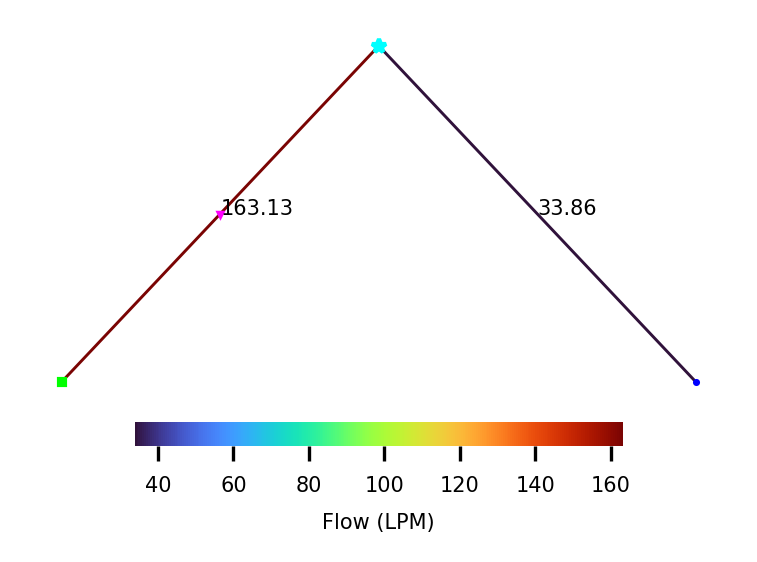

In [9]:
_ = d.plot(flow=F[48], flow_text=True)

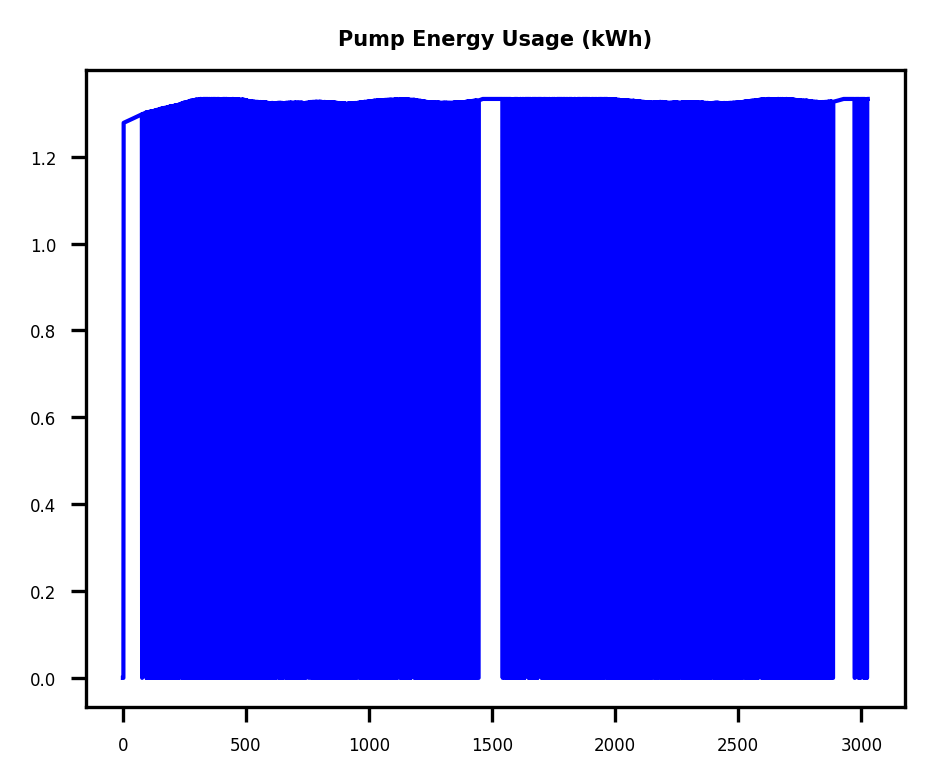

In [10]:
d.plot_ts(Y=E, title="Pump Energy Usage (kWh)", marker=False)

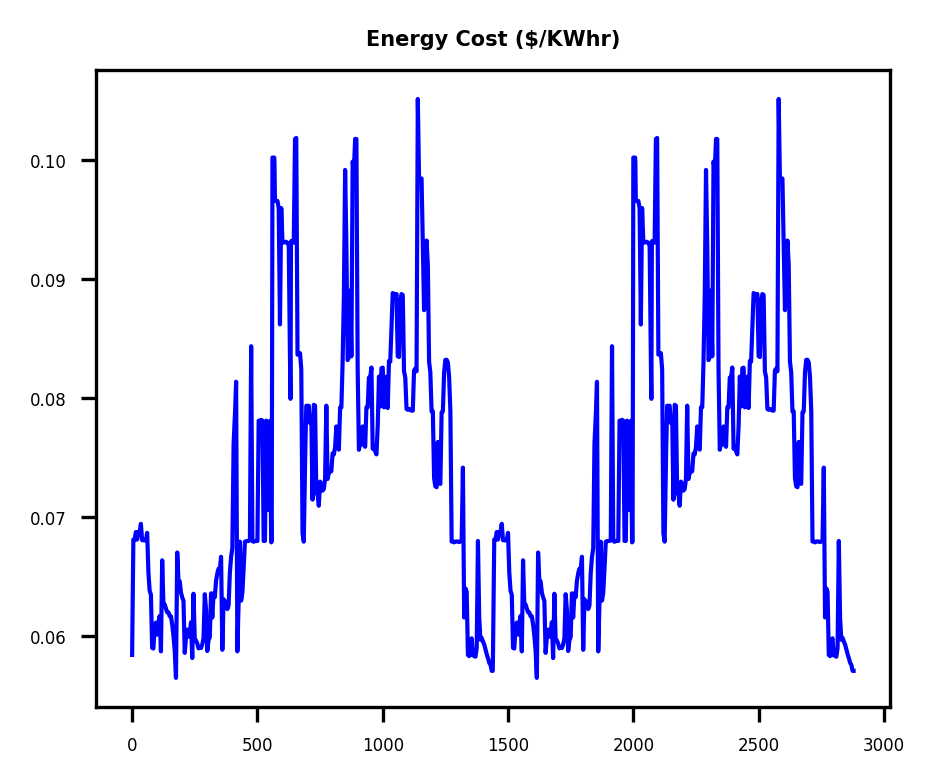

In [11]:
d.plot_ts(Y=electricity_rate(np.arange(N_SIMULATION_STEPS)), title="Energy Cost ($/KWhr)", marker=False)

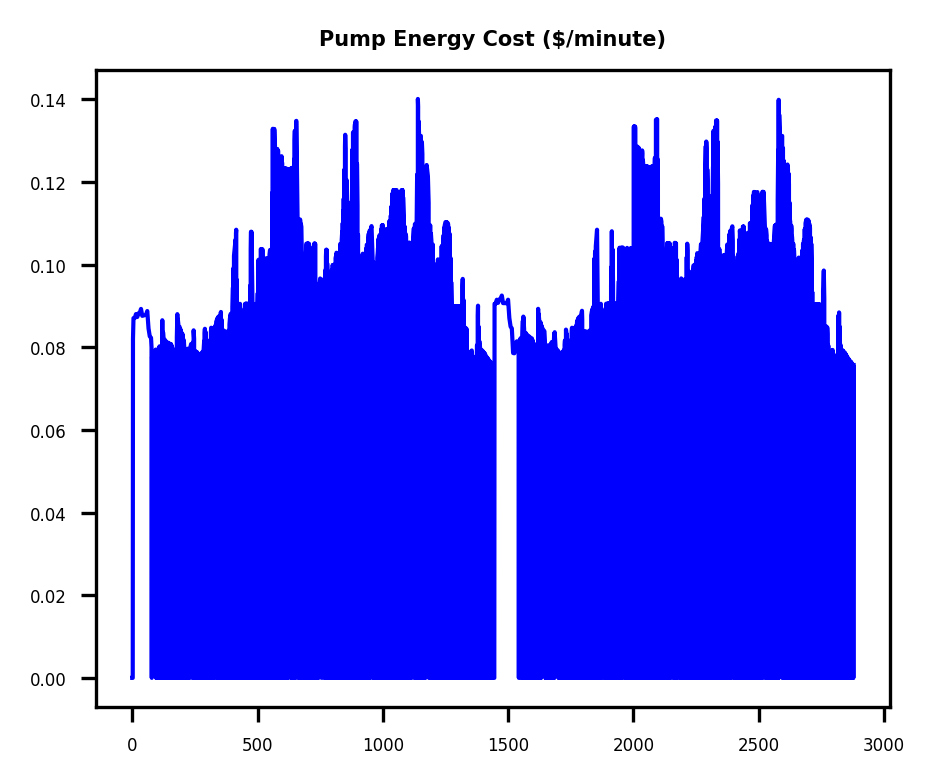

In [12]:
d.plot_ts(Y=np.array(E[:2880]) * electricity_rate(np.arange(N_SIMULATION_STEPS)), title="Pump Energy Cost ($/minute)", marker=False)

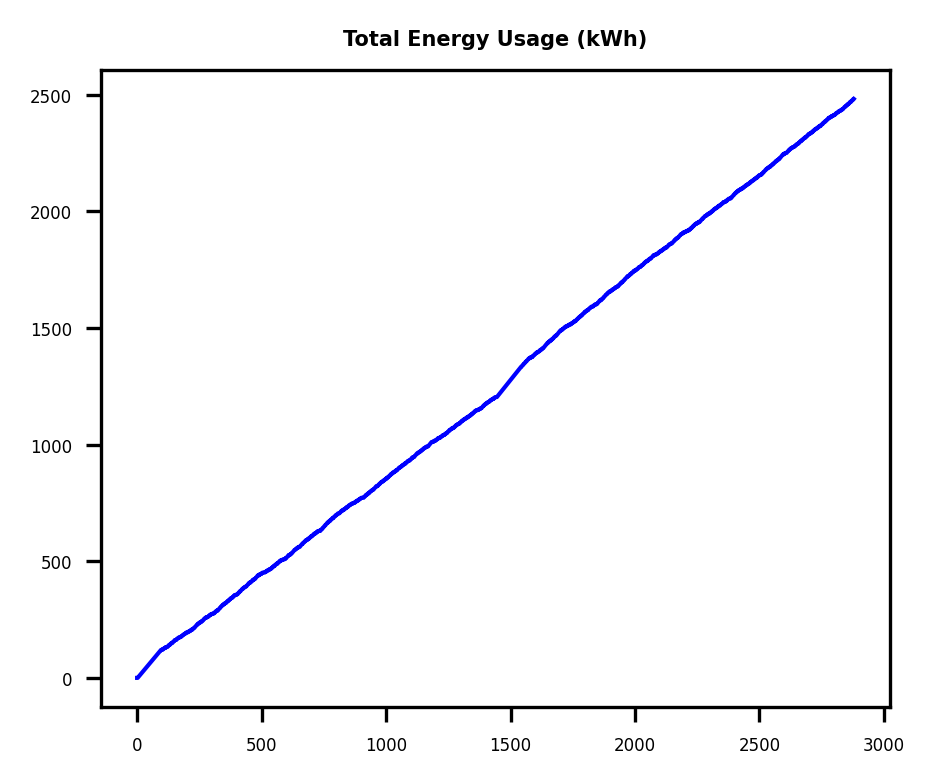

In [13]:
d.plot_ts(Y=np.cumsum(E[:2880]), title="Total Energy Usage (kWh)", marker=False)

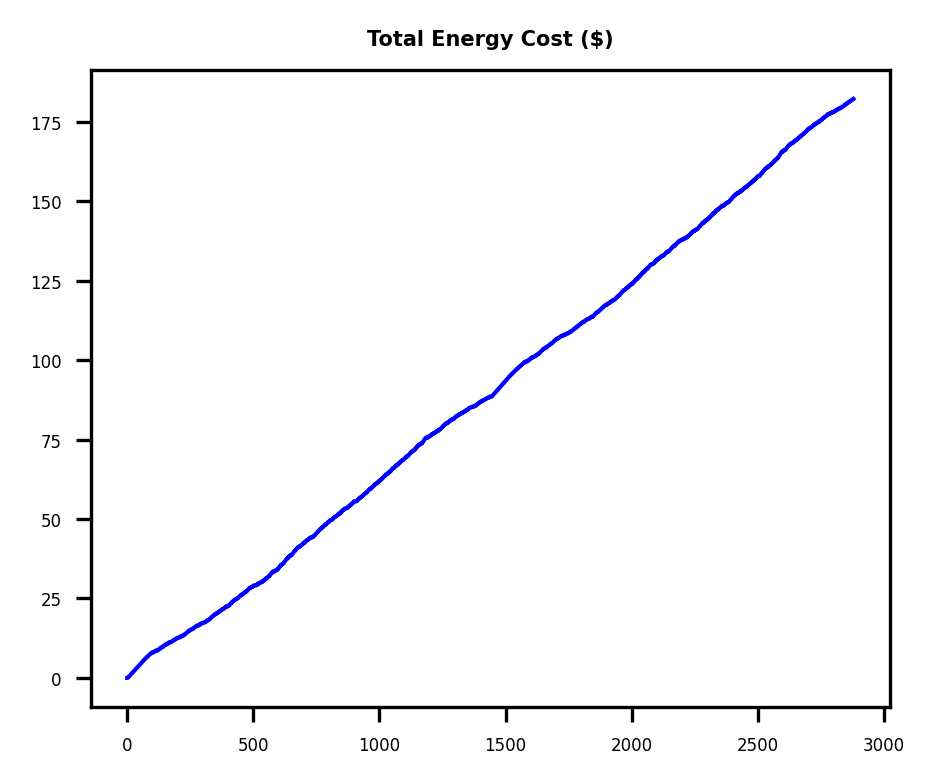

In [14]:
d.plot_ts(Y=np.cumsum(np.array(E[:2880]) * electricity_rate(np.arange(N_SIMULATION_STEPS))), title="Total Energy Cost ($)", marker=False)

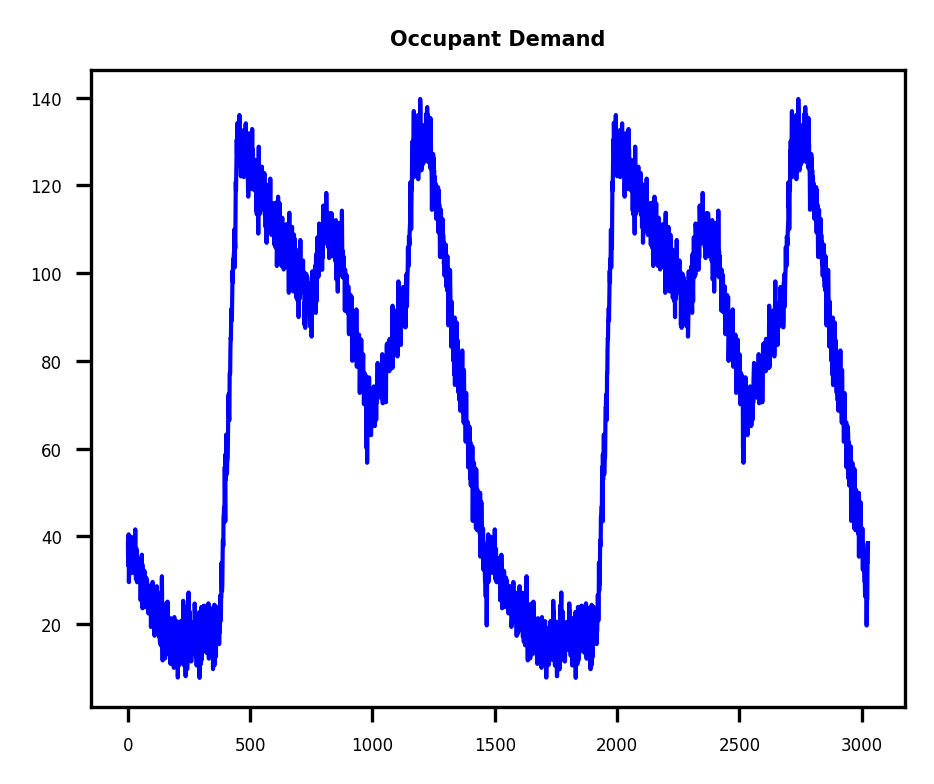

In [15]:
d.plot_ts(Y=np.array(F)[:, 0], title="Occupant Demand", marker=False)

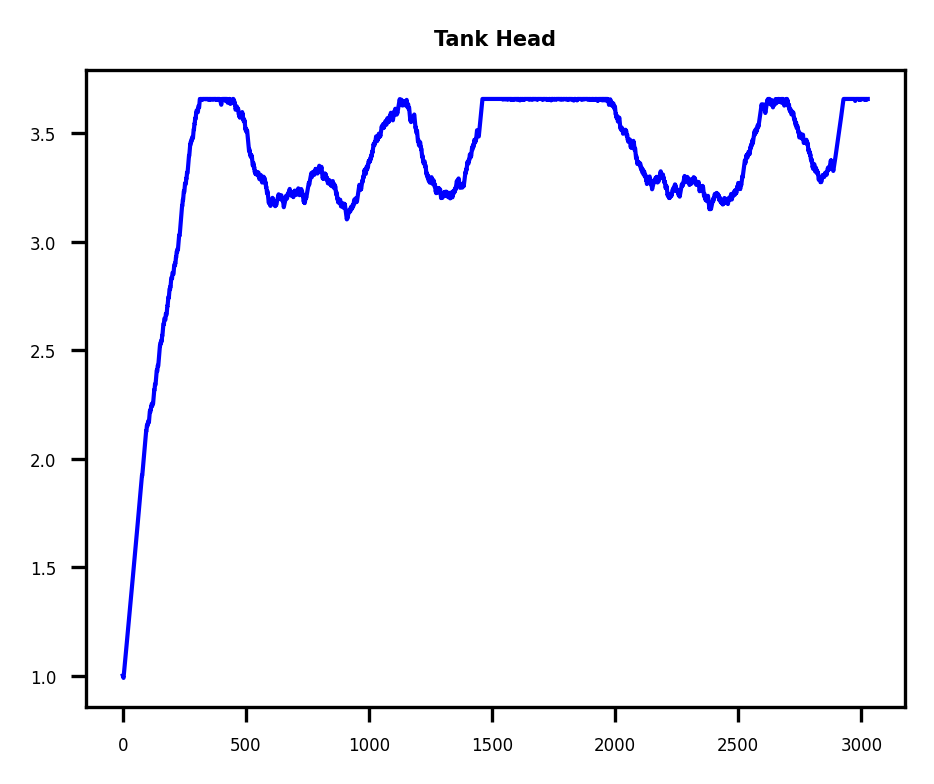

In [16]:
d.plot_ts(Y=tankHead, title='Tank Head', marker=False)

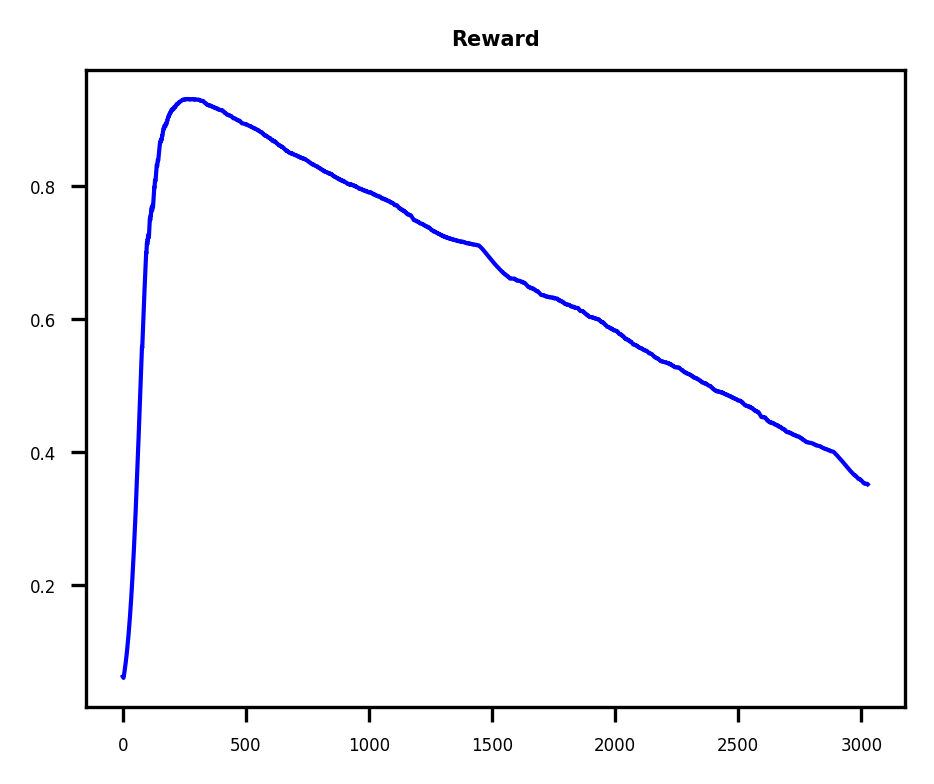

In [17]:
d.plot_ts(Y=R, title='Reward', marker=False)

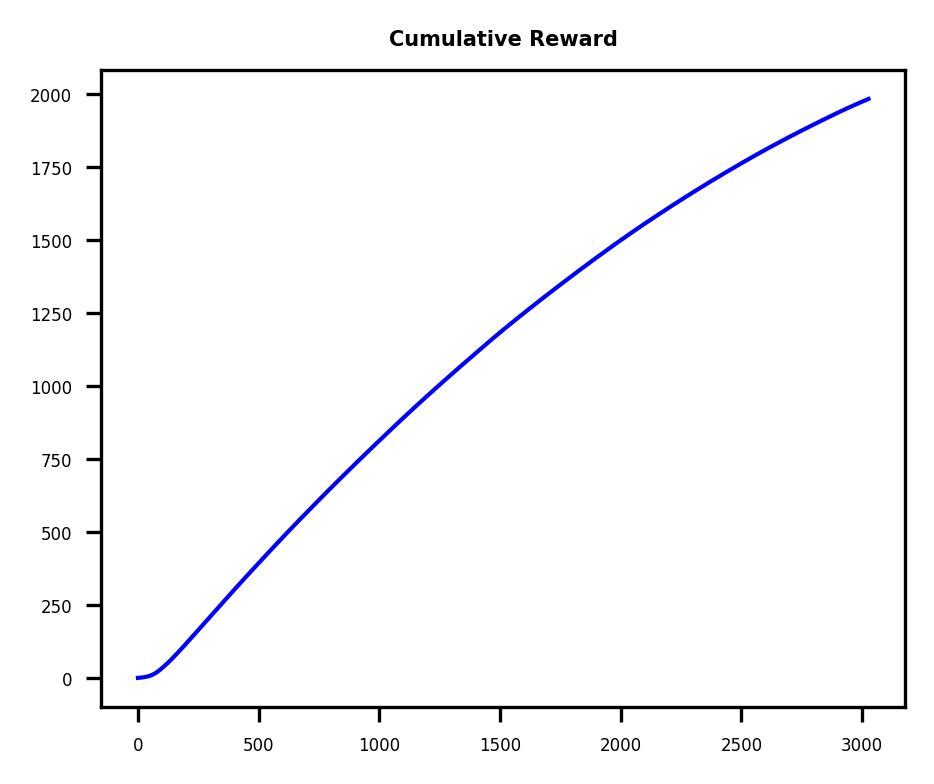

In [18]:
d.plot_ts(Y=np.cumsum(R), title='Cumulative Reward', marker=False)